In [3]:
from Bio import SeqIO
import pandas as pd

In [72]:
def process_kraken_out(filename):
    seqs = {'classified': [], 'id': [], 'taxa_id': [], 'len': [], 'cl_k_mer': [], 'cl_string': []}
    with open(filename, 'r') as ifile:
        for line in ifile:
            tokens = line.split()
            seqs['classified'].append(tokens[0])
            seqs['id'].append(tokens[1])
            seqs['taxa_id'].append(int(tokens[2]))
            seqs['len'].append(int(tokens[3]))
            cl_k_mer = 0
            for pair in tokens[4:]:
                pair = pair.split(':')
                if pair[0] == tokens[2]:
                    cl_k_mer += int(pair[1])
            seqs['cl_k_mer'].append(cl_k_mer)
            seqs['cl_string'].append('_'.join(tokens[4:]))
            
    return pd.DataFrame(seqs)

In [73]:
df = process_kraken_out('kraken_male.out')

In [74]:
df['ratio'] = df['cl_k_mer'] / df['len']

<AxesSubplot:>

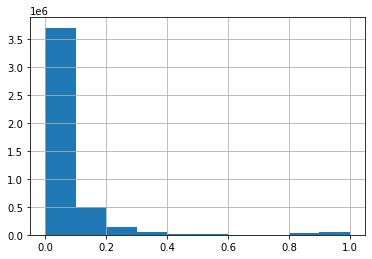

In [75]:
df.ratio.hist()

In [77]:
df[df['ratio'] > 0.8].taxa_id.unique()

array([    0,  7165, 44542,  2759])

In [62]:
df[(df['ratio'] > 0.2) & (df['taxa'] == 36805)]

,classified,id,taxa,len,cl_k_mer,cl_string,ratio
1243556,C,69379a9e-a4a2-4eda-9d0d-51af888dd6b4,36805,414,138,36805:3_0:8_36805:4_0:1_36805:5_0:32_36805:5_0...,0.333333


In [56]:
def get_read(filename, read_id):
    for rec in SeqIO.parse(filename, 'fastq'):
        if read_id in rec.description:
            return str(rec.seq)

In [60]:
print(get_read('../female2_fc1_fc2.fq', '08bc1e56-a910-4e14-a26b-1f061f6527eb'))

GTTAATACTTCGTTCAGTTGTATTGCGCAGGTCGATCGACTGGGTCAGTCAGGCGGTCGCACCCGCCGAGGCCGACTTCAGCCCCACCGATCCACAAATCGCCTTTCATCGCCTTCCATCGAACTGGGTTCGCAGCATCCCGGCGGACGCGATCATCATGCGTCAGAACTGGCTACGGGCGTACGACTTCACAACTGATCGCGGCGCCATGGCGCTCAGCGACTATGCTCGCTCGAACGACCCGTTCACGCGGGTCGGCCGACAGCAGAGTTGCTATCGATGTCTCAAGCGTCATCCGCGCCCCTCGCCCCGACAGCAATACGTAGC


In [1]:
import csv
from ete3 import NCBITaxa
import pandas as pd
from Bio import SeqIO

/GWSPH/groups/cbi/Users/azamyatin/miniconda3/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/GWSPH/groups/cbi/Users/azamyatin/miniconda3/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [17]:
desired_ranks = ['superkingdom', 'kingdom'] #, 'phylum', 'class', 'order', 'family', 'genus', 'species']

In [7]:
ncbi = NCBITaxa()

In [9]:
def get_desired_ranks(taxid, desired_ranks):
    lineage = ncbi.get_lineage(taxid)   
    names = ncbi.get_taxid_translator(lineage)
    lineage2ranks = ncbi.get_rank(names)
    ranks2lineage = dict((rank,taxid) for (taxid, rank) in lineage2ranks.items())
    return{'{}_id'.format(rank): ranks2lineage.get(rank, '<not present>') for rank in desired_ranks}

In [ ]:
kingdoms = {0: "unclassified", 119065: "Bacteria", 131567: 'unclassified', 1: 'unclassified'}
taxonomy = {0: ["NA"] * 8,
            119065: ["Bacteria"] + ['NA'] * 7}
desired_ranks = ['superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
for taxid in df['taxa_id']:
    if taxid != 0 and taxid not in taxonomy.keys():
        ranks = get_desired_ranks(taxid, desired_ranks)
        taxonomy[taxid] = []
        for key, rank in ranks.items():
            if rank != '<not present>':
                taxonomy[taxid].append(list(ncbi.get_taxid_translator([rank]).values())[0])
            else:
                taxonomy[taxid].append('NA')

In [79]:
df['superkingdom'] = [taxonomy[taxid][0] for taxid in df['taxa_id']]
df['kingdom'] = [taxonomy[taxid][1] for taxid in df['taxa_id']]
df['phylum'] = [taxonomy[taxid][2] for taxid in df['taxa_id']]
df['class'] = [taxonomy[taxid][3] for taxid in df['taxa_id']]
df['order'] = [taxonomy[taxid][4] for taxid in df['taxa_id']]
df['family'] = [taxonomy[taxid][5] for taxid in df['taxa_id']]
df['genus'] = [taxonomy[taxid][6] for taxid in df['taxa_id']]
df['species'] = [taxonomy[taxid][7] for taxid in df['taxa_id']]

In [53]:
df = df.drop('taxa', 1)

# FEMALE

In [58]:
df.groupby('superkingdom').agg('count')['classified']

superkingdom
Archaea           10
Bacteria        2035
Eukaryota    2529724
NA             21093
Viruses            3
Name: classified, dtype: int64

In [69]:
df.groupby('superkingdom').agg('sum')['len']

superkingdom
Archaea             8582
Bacteria         7773309
Eukaryota    19770438497
NA               9092742
Viruses             1712
Name: len, dtype: int64

In [86]:
good = 2529724 + 21093
cont = 10 + 2035 + 3
answ = good/(good+cont) * 100
print(answ, 100-answ)

99.91977640807484 0.08022359192516149


# MALE

In [80]:
df.groupby('superkingdom').agg('count')['classified']

superkingdom
Archaea           62
Bacteria       24242
Eukaryota    4398085
NA             80867
Viruses           19
Name: classified, dtype: int64

In [81]:
df.groupby('superkingdom').agg('sum')['len']

superkingdom
Archaea            56503
Bacteria        49845129
Eukaryota    24233511790
NA              38540760
Viruses            26205
Name: len, dtype: int64

In [87]:
good = 4398085 + 80867
cont = 62 + 24242 + 19
answ = good/(good+cont) * 100
print(answ, 100-answ)

99.45988197478502 0.54011802521498


In [82]:
good_reads = set(df[df['superkingdom'].isin(["Eukaryota", 'NA'])].id)

In [83]:
filtered_out = open('male_filtered_reads.fq', 'w')
contaminants_out = open('male_contaminants_reads.fq', 'w')
for rec in SeqIO.parse('../male22_fc1_fc2.fq', 'fastq'):
    if rec.description.split()[0] in good_reads:
        SeqIO.write(rec, filtered_out, 'fastq')
    else:
        SeqIO.write(rec, contaminants_out, 'fastq')
filtered_out.close()
contaminants_out.close()